<a href="https://colab.research.google.com/github/gbaghdadi/NeuromatchDeepLearningProject/blob/main/NMAproject2023_PytorchRegression_StringerData_RunSpeed_PlayWithDifferentFactors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.model_selection import KFold


In [2]:
# @title NMA Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
# @title NMA Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [4]:
# @title NMA Data loading

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


In [5]:
# @title Shape of each data

print('neuralActivity dimension:   ', dat['sresp'].shape)
print('stat dimension:  ', dat['stat'].shape)
print('running speed dimension:  ', dat['run'].shape)
print('pupil area dimension:  ', dat['pupilArea'].shape)
print('pupil xy position dimension:  ', dat['pupilCOM'].shape)
print('faceSVD dimension:   ',dat['beh_svd_time'].shape)

neuralActivity dimension:    (11983, 7018)
stat dimension:   (11983, 1)
running speed dimension:   (7018, 1)
pupil area dimension:   (7018, 1)
pupil xy position dimension:   (7018, 2)
faceSVD dimension:    (7018, 1000)


In [6]:
# @title Input and Output of the Model

neural_activity = dat['sresp']    # Input
run_speed = dat['run']            # Output
pupil_area = dat['pupilArea']     # Output
face_svd = dat['beh_svd_time']    # Output

print('Input dimension:  ', neural_activity.shape)
print('Output dimension:  ',run_speed.shape)

print('Output dimension(face SVD):  ',face_svd.shape)


Input dimension:   (11983, 7018)
Output dimension:   (7018, 1)
Output dimension(face SVD):   (7018, 1000)


In [7]:
# reshaping input and output
neural_activity = np.transpose(neural_activity)
runspeed = run_speed.squeeze()
pupilarea = pupil_area.squeeze()
facesvd = face_svd[:,:100]

print('Input dimension:  ', neural_activity.shape)
print('Output dimension:  ',runspeed.shape)
print('Output dimension (face SVD):  ',facesvd.shape)

Input dimension:   (7018, 11983)
Output dimension:   (7018,)
Output dimension (face SVD):   (7018, 100)


#**Pytorch Regression Model: neural activity -> running speed**

adapted from "https://machinelearningmastery.com/building-a-regression-model-in-pytorch/"

# **Playing with number of neurons (One Relu layer)**

number of neurons is changed from 10 to 400 by step 50

In [8]:
import torch.nn as nn
import torch.nn as nn
import torch.optim as optim
import copy
import numpy as np
import torch
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Dimension Reduction of the Input using PCA
pca_model = PCA(n_components=500)
reduced = pca_model.fit_transform(neural_activity)
component = pca_model.components_
neural_activity = reduced
print(neural_activity.shape)
# print(component.shape)


X = neural_activity
y = runspeed
print('Input shape:  ', X.shape)
print('Output shape:  ', y.shape)

errortest_neuron_num = []
errortrain_neuron_num = []

for num_neuron in np.arange(10,400,step = 50):

    model = nn.Sequential(
    nn.Linear(500, num_neuron),
    nn.ReLU(),
    nn.Linear(num_neuron, 1)
    )

    # loss function and optimizer
    loss_fn = nn.MSELoss()  # mean square error
    optimizer = optim.Adam(model.parameters(), lr=0.0001)


    # train-test split for model evaluation
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=False)

    # Standardizing data
    scaler = StandardScaler()
    scaler.fit(X_train_raw)
    X_train = scaler.transform(X_train_raw)
    X_test = scaler.transform(X_test_raw)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)#.reshape(-1, 1)
    y_train = torch.tensor(y_train, dtype=torch.float32)#.reshape(-1, 1)



    print('X train shape:  ', X_train.shape)
    print('y train shape:  ',y_train.shape)
    print('X test shape:   ', X_test.shape)
    print('y test shape:  ', y_test.shape)

    # training parameters
    n_epochs = 100   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_mse_train = np.inf
    best_weights = None
    history = []
    history_train = []


    # training loop
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                bar.set_postfix(mse=float(loss))
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())

        # restore model and return best accuracy
        model.load_state_dict(best_weights)
        y_predict = model(X_train)
        mse_train = loss_fn(y_predict, y_train)
        mse_train = float(mse_train)
        history_train.append(mse_train)
        if mse_train < best_mse_train:
            best_mse_train = mse_train

    errortrain_neuron_num.append(best_mse_train)
    errortest_neuron_num.append(best_mse)


(7018, 500)
Input shape:   (7018, 500)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 500])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 500])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

X train shape:   torch.Size([4912, 500])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 500])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

X train shape:   torch.Size([4912, 500])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 500])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

X train shape:   torch.Size([4912, 500])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 500])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

X train shape:   torch.Size([4912, 500])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 500])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

X train shape:   torch.Size([4912, 500])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 500])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

X train shape:   torch.Size([4912, 500])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 500])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

X train shape:   torch.Size([4912, 500])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 500])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

MSE Train: 59.59
RMSE Train: 7.72
MSE Test: 133.85
RMSE Test: 11.57


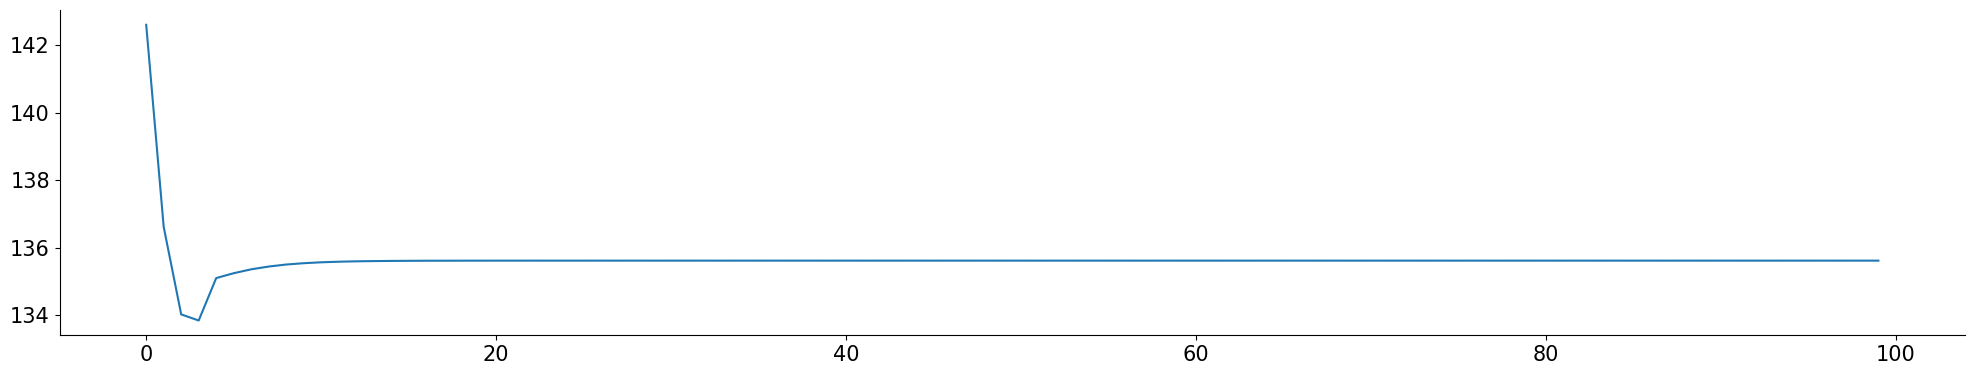

In [9]:

print("MSE Train: %.2f" % best_mse_train)
print("RMSE Train: %.2f" % np.sqrt(best_mse_train))

print("MSE Test: %.2f" % best_mse)
print("RMSE Test: %.2f" % np.sqrt(best_mse))

plt.plot(history)
plt.show()

MSE_train: 
[63.09962463378906, 61.139259338378906, 60.843360900878906, 60.276771545410156, 60.26508331298828, 59.8216438293457, 59.66365051269531, 59.59407424926758]
MSE_test: 
[141.93812561035156, 137.04580688476562, 136.72093200683594, 135.26754760742188, 134.89031982421875, 134.16165161132812, 133.9113006591797, 133.85189819335938]


Text(0, 0.5, 'MSE test')

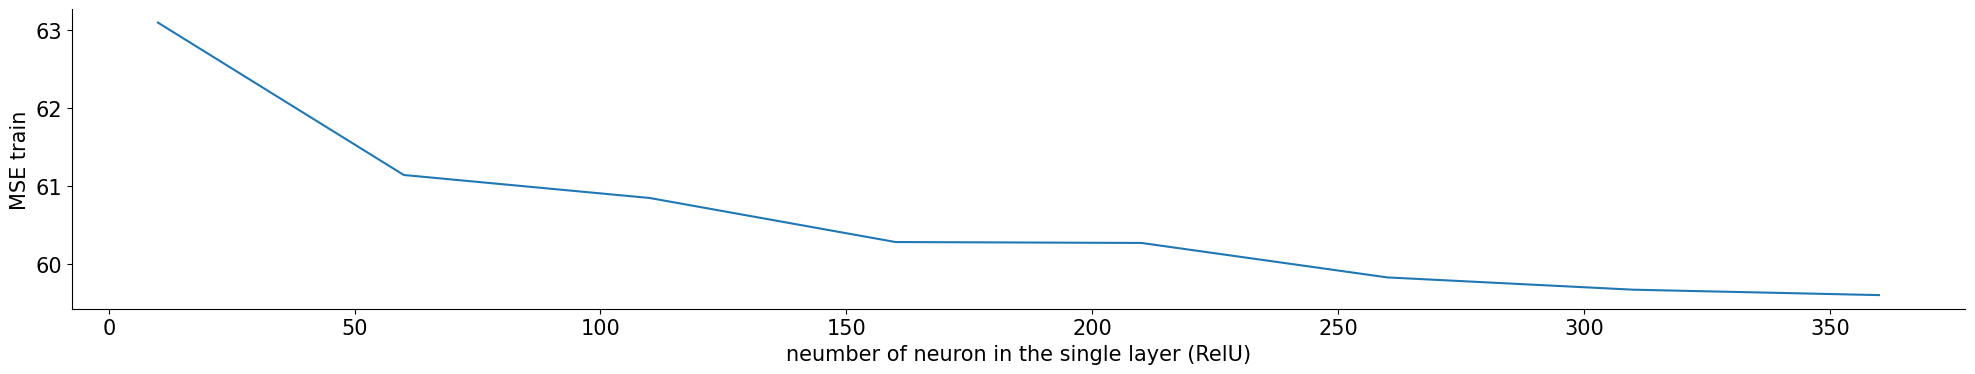

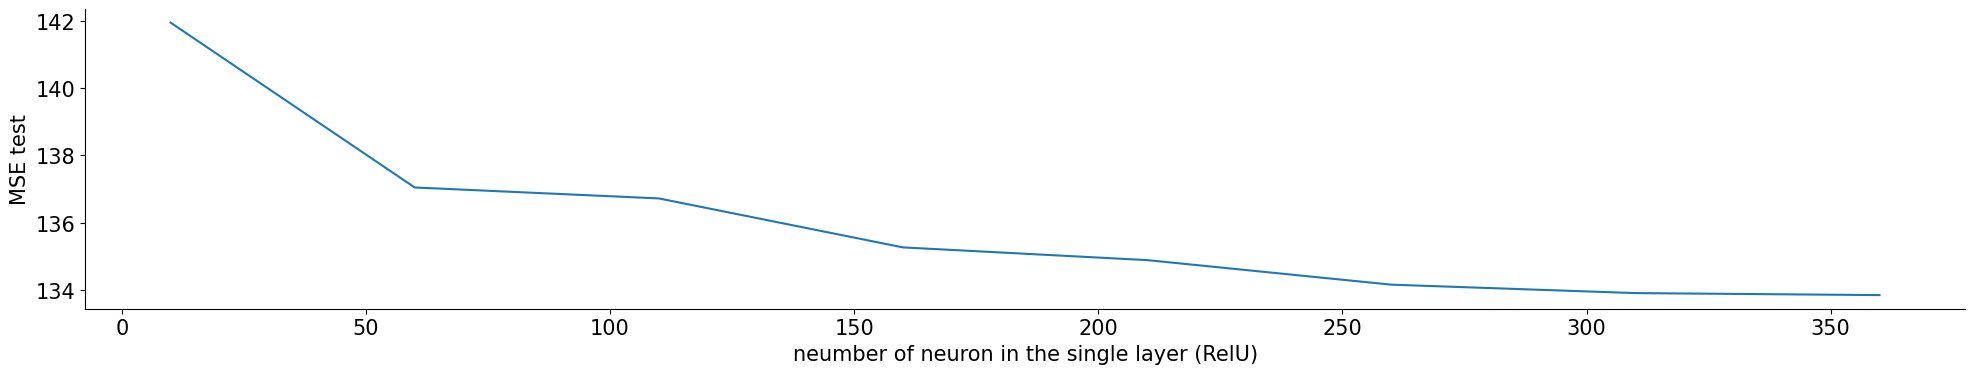

In [10]:
# @title Prining and showing the results of playing with number of neurons
num_neuron = np.arange(10,400,step = 50)

print("MSE_train: ")
print(errortrain_neuron_num)
plt.figure()
plt.plot(num_neuron, errortrain_neuron_num)
plt.xlabel('neumber of neuron in the single layer (RelU)')
plt.ylabel('MSE train')


print("MSE_test: ")
print(errortest_neuron_num)
plt.figure()
plt.plot(num_neuron, errortest_neuron_num)
plt.xlabel('neumber of neuron in the single layer (RelU)')
plt.ylabel('MSE test')


# **Playing with number of layers**

We considered four conditions:

1- Two Relu hiddern layers: number of neurons in each layer: [400 10]

2- Two Relu hiddern layers: number of neurons in each layer: [400 100]

3- Three Relu hiddern layers: number of neurons in each layer: [400 10 10]

4- Three Relu hiddern layers: number of neurons in each layer: ?


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

MSE Train: 59.32
RMSE Train: 7.70
MSE Test: 132.96
RMSE Test: 11.53


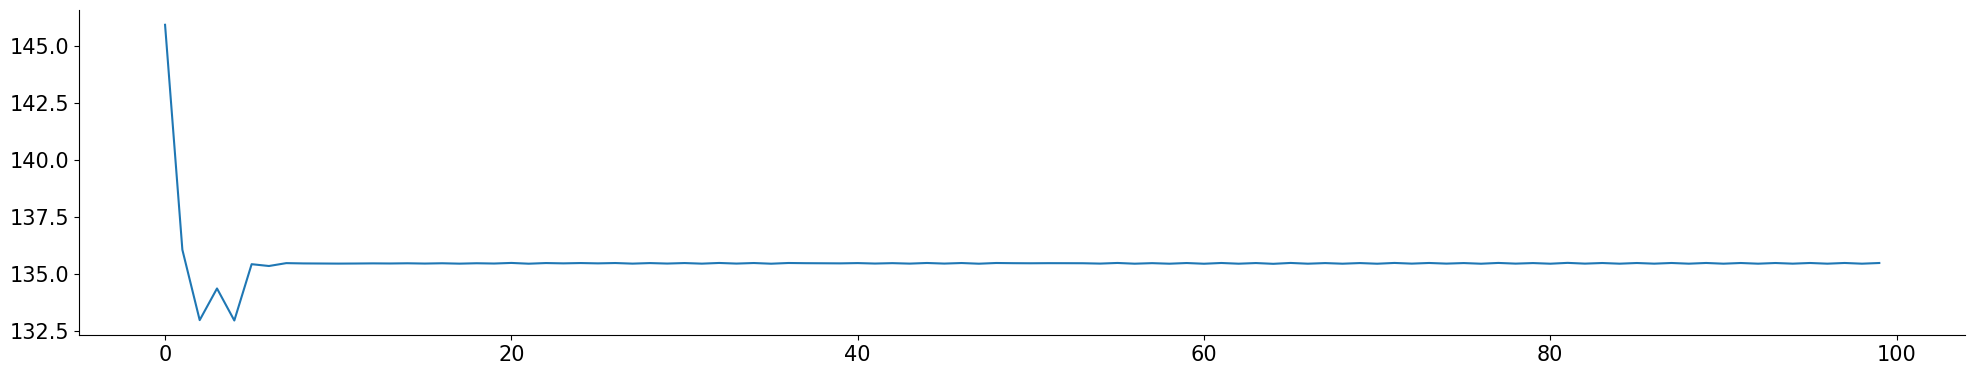

In [11]:
# @title **1st condition** : Two Relu hiddern layers: number of neurons in each layer: [400 10]


errortest_neuron_num = []
errortrain_neuron_num = []

num_neuron2 = 10  #secend layer

for num_neuron in [400]:     # first layer # there is no need for "for", it is just a fast draft of chaning the code for our investigation

    model = nn.Sequential(
    nn.Linear(500, num_neuron),
    nn.ReLU(),
    nn.Linear(num_neuron, num_neuron2),
    nn.ReLU(),
    nn.Linear(num_neuron2, 1)
    )

    # loss function and optimizer
    loss_fn = nn.MSELoss()  # mean square error
    optimizer = optim.Adam(model.parameters(), lr=0.0001)


    # train-test split for model evaluation
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=False)

    # Standardizing data
    scaler = StandardScaler()
    scaler.fit(X_train_raw)
    X_train = scaler.transform(X_train_raw)
    X_test = scaler.transform(X_test_raw)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)#.reshape(-1, 1)
    y_train = torch.tensor(y_train, dtype=torch.float32)#.reshape(-1, 1)


    # training parameters
    n_epochs = 100   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_mse_train = np.inf
    best_weights = None
    history = []
    history_train = []

    # training loop
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                bar.set_postfix(mse=float(loss))
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())

        # restore model and return best accuracy
        model.load_state_dict(best_weights)
        y_predict = model(X_train)
        mse_train = loss_fn(y_predict, y_train)
        mse_train = float(mse_train)
        history_train.append(mse_train)
        if mse_train < best_mse_train:
            best_mse_train = mse_train

    errortrain_neuron_num.append(best_mse_train)
    errortest_neuron_num.append(best_mse)


print("#######################################################################")
print("MSE Train: %.2f" % best_mse_train)
print("RMSE Train: %.2f" % np.sqrt(best_mse_train))

print("MSE Test: %.2f" % best_mse)
print("RMSE Test: %.2f" % np.sqrt(best_mse))

plt.plot(history)
plt.show()




/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

#######################################################################
MSE Train: 58.63
RMSE Train: 7.66
MSE Test: 131.98
RMSE Test: 11.49


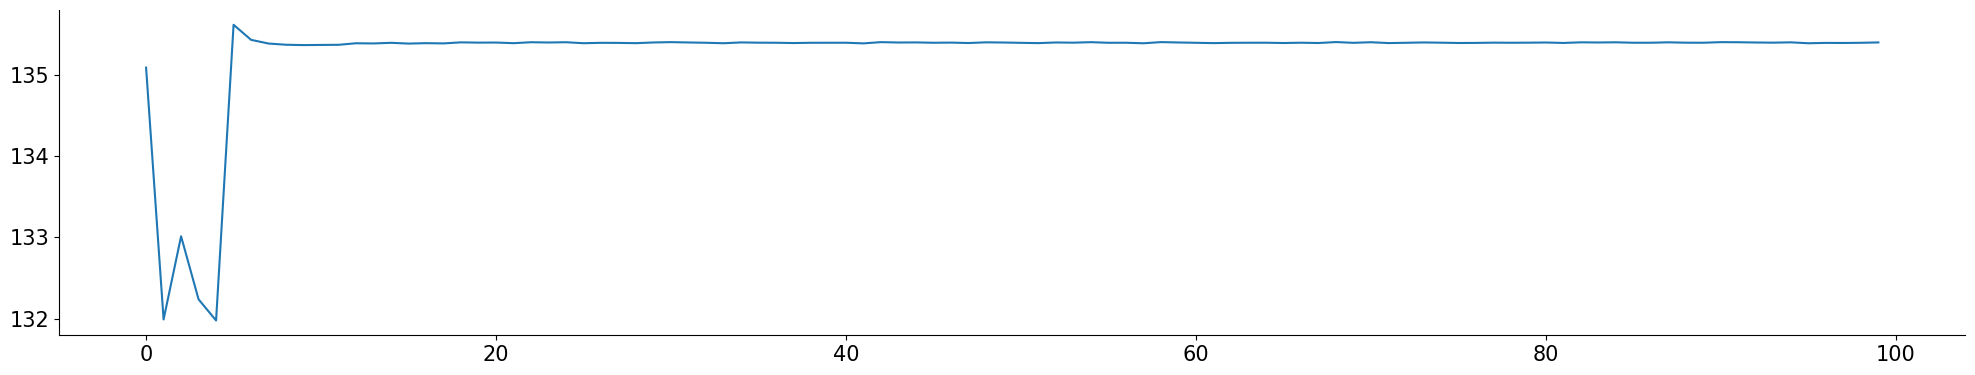

In [12]:
# @title **2ed condition** : Two Relu hiddern layers: number of neurons in each layer: [400 100]


errortest_neuron_num = []
errortrain_neuron_num = []

num_neuron2 = 100  #secend layer

for num_neuron in [400]:     # first layer # there is no need for "for", it is just a fast draft of chaning the code for our investigation

    model = nn.Sequential(
    nn.Linear(500, num_neuron),
    nn.ReLU(),
    nn.Linear(num_neuron, num_neuron2),
    nn.ReLU(),
    nn.Linear(num_neuron2, 1)
    )

    # loss function and optimizer
    loss_fn = nn.MSELoss()  # mean square error
    optimizer = optim.Adam(model.parameters(), lr=0.0001)


    # train-test split for model evaluation
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=False)

    # Standardizing data
    scaler = StandardScaler()
    scaler.fit(X_train_raw)
    X_train = scaler.transform(X_train_raw)
    X_test = scaler.transform(X_test_raw)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)#.reshape(-1, 1)
    y_train = torch.tensor(y_train, dtype=torch.float32)#.reshape(-1, 1)


    # training parameters
    n_epochs = 100   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_mse_train = np.inf
    best_weights = None
    history = []
    history_train = []

    # training loop
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                bar.set_postfix(mse=float(loss))
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())

        # restore model and return best accuracy
        model.load_state_dict(best_weights)
        y_predict = model(X_train)
        mse_train = loss_fn(y_predict, y_train)
        mse_train = float(mse_train)
        history_train.append(mse_train)
        if mse_train < best_mse_train:
            best_mse_train = mse_train

    errortrain_neuron_num.append(best_mse_train)
    errortest_neuron_num.append(best_mse)

print("#######################################################################")
print("MSE Train: %.2f" % best_mse_train)
print("RMSE Train: %.2f" % np.sqrt(best_mse_train))

print("MSE Test: %.2f" % best_mse)
print("RMSE Test: %.2f" % np.sqrt(best_mse))

plt.plot(history)
plt.show()




/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

#######################################################################
MSE Train: 65.73
RMSE Train: 8.11
MSE Test: 156.40
RMSE Test: 12.51


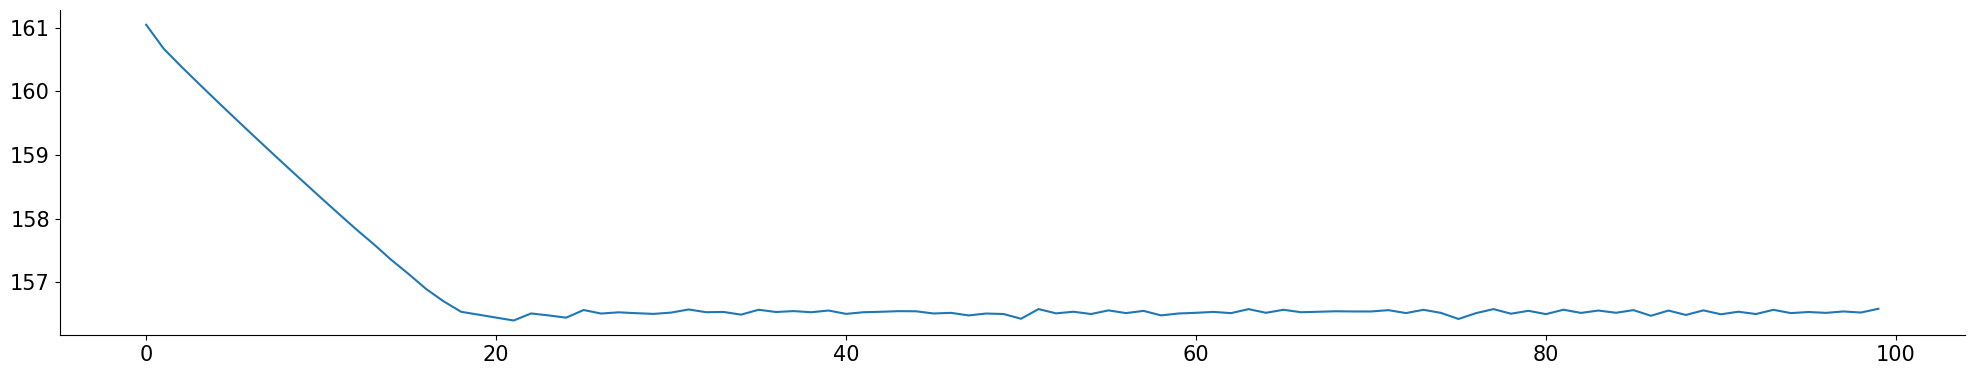

In [13]:
# @title **3rd condition** : Three Relu hiddern layers: number of neurons in each layer: [400 10 10]

errortest_neuron_num = []
errortrain_neuron_num = []
num_neuron2 = 10   #second layer
num_neuron3 = 10   #third layer

for num_neuron in [400]:  # first layer # there is no need for "for", it is just a fast draft of chaning the code for our investigation

    model = nn.Sequential(
    nn.Linear(500, num_neuron),
    nn.ReLU(),
    nn.Linear(num_neuron, num_neuron2),
    nn.ReLU(),
    nn.Linear(num_neuron2, num_neuron3),
    nn.ReLU(),
    nn.Linear(num_neuron3, 1)
    )

    # loss function and optimizer
    loss_fn = nn.MSELoss()  # mean square error
    optimizer = optim.Adam(model.parameters(), lr=0.0001)


    # train-test split for model evaluation
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=False)

    # Standardizing data
    scaler = StandardScaler()
    scaler.fit(X_train_raw)
    X_train = scaler.transform(X_train_raw)
    X_test = scaler.transform(X_test_raw)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)#.reshape(-1, 1)
    y_train = torch.tensor(y_train, dtype=torch.float32)#.reshape(-1, 1)

    # training parameters
    n_epochs = 100   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_mse_train = np.inf
    best_weights = None
    history = []
    history_train = []


    # training loop
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                bar.set_postfix(mse=float(loss))
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())

        # restore model and return best accuracy
        model.load_state_dict(best_weights)
        y_predict = model(X_train)
        mse_train = loss_fn(y_predict, y_train)
        mse_train = float(mse_train)
        history_train.append(mse_train)
        if mse_train < best_mse_train:
            best_mse_train = mse_train

    errortrain_neuron_num.append(best_mse_train)
    errortest_neuron_num.append(best_mse)


print("#######################################################################")
print("MSE Train: %.2f" % best_mse_train)
print("RMSE Train: %.2f" % np.sqrt(best_mse_train))

print("MSE Test: %.2f" % best_mse)
print("RMSE Test: %.2f" % np.sqrt(best_mse))

plt.plot(history)
plt.show()


# **Playing with activation functions**

We investigated two activation functions in the following conditions:

1- One layer with 400 neurons with Sigmoid activation function

2- Two layers with [400 10] neurons with Sigmoid activation function

3- One layer with 400 neurons with Tanh activation function

4- Two layers with [400 10] neurons with Tanh activation function

In [ ]:
# @title **1st condition** :  One layer with 400 neurons with Sigmoid activation function


errortest_neuron_num = []
errortrain_neuron_num = []

for num_neuron in [400]:     # first layer # there is no need for "for", it is just a fast draft of chaning the code for our investigation

    model = nn.Sequential(
    nn.Linear(500, num_neuron),
    nn.Sigmoid(),
    nn.Linear(num_neuron, 1)
    )

    # loss function and optimizer
    loss_fn = nn.MSELoss()  # mean square error
    optimizer = optim.Adam(model.parameters(), lr=0.0001)


    # train-test split for model evaluation
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=False)

    # Standardizing data
    scaler = StandardScaler()
    scaler.fit(X_train_raw)
    X_train = scaler.transform(X_train_raw)
    X_test = scaler.transform(X_test_raw)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)#.reshape(-1, 1)
    y_train = torch.tensor(y_train, dtype=torch.float32)#.reshape(-1, 1)


    # training parameters
    n_epochs = 100   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_mse_train = np.inf
    best_weights = None
    history = []
    history_train = []

    # training loop
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                bar.set_postfix(mse=float(loss))
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())

        # restore model and return best accuracy
        model.load_state_dict(best_weights)
        y_predict = model(X_train)
        mse_train = loss_fn(y_predict, y_train)
        mse_train = float(mse_train)
        history_train.append(mse_train)
        if mse_train < best_mse_train:
            best_mse_train = mse_train

    errortrain_neuron_num.append(best_mse_train)
    errortest_neuron_num.append(best_mse)


print("#######################################################################")
print("MSE Train: %.2f" % best_mse_train)
print("RMSE Train: %.2f" % np.sqrt(best_mse_train))

print("MSE Test: %.2f" % best_mse)
print("RMSE Test: %.2f" % np.sqrt(best_mse))

plt.plot(history)
plt.show()




In [ ]:
# @title **2ed condition** : Two layers with [400 10] neurons with Sigmoid activation function

errortest_neuron_num = []
errortrain_neuron_num = []

num_neuron2 = 10  #secend layer

for num_neuron in [400]:     # first layer # there is no need for "for", it is just a fast draft of chaning the code for our investigation

    model = nn.Sequential(
    nn.Linear(500, num_neuron),
    nn.Sigmoid(),
    nn.Linear(num_neuron, num_neuron2),
    nn.Sigmoid(),
    nn.Linear(num_neuron2, 1)
    )

    # loss function and optimizer
    loss_fn = nn.MSELoss()  # mean square error
    optimizer = optim.Adam(model.parameters(), lr=0.0001)


    # train-test split for model evaluation
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=False)

    # Standardizing data
    scaler = StandardScaler()
    scaler.fit(X_train_raw)
    X_train = scaler.transform(X_train_raw)
    X_test = scaler.transform(X_test_raw)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)#.reshape(-1, 1)
    y_train = torch.tensor(y_train, dtype=torch.float32)#.reshape(-1, 1)


    # training parameters
    n_epochs = 100   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_mse_train = np.inf
    best_weights = None
    history = []
    history_train = []

    # training loop
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                bar.set_postfix(mse=float(loss))
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())

        # restore model and return best accuracy
        model.load_state_dict(best_weights)
        y_predict = model(X_train)
        mse_train = loss_fn(y_predict, y_train)
        mse_train = float(mse_train)
        history_train.append(mse_train)
        if mse_train < best_mse_train:
            best_mse_train = mse_train

    errortrain_neuron_num.append(best_mse_train)
    errortest_neuron_num.append(best_mse)


print("#######################################################################")
print("MSE Train: %.2f" % best_mse_train)
print("RMSE Train: %.2f" % np.sqrt(best_mse_train))

print("MSE Test: %.2f" % best_mse)
print("RMSE Test: %.2f" % np.sqrt(best_mse))

plt.plot(history)
plt.show()




In [ ]:
# @title **3rd condition** :  One layer with 400 neurons with Tanh activation function


errortest_neuron_num = []
errortrain_neuron_num = []

for num_neuron in [400]:     # first layer # there is no need for "for", it is just a fast draft of chaning the code for our investigation

    model = nn.Sequential(
    nn.Linear(500, num_neuron),
    nn.Tanh(),
    nn.Linear(num_neuron, 1)
    )

    # loss function and optimizer
    loss_fn = nn.MSELoss()  # mean square error
    optimizer = optim.Adam(model.parameters(), lr=0.0001)


    # train-test split for model evaluation
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=False)

    # Standardizing data
    scaler = StandardScaler()
    scaler.fit(X_train_raw)
    X_train = scaler.transform(X_train_raw)
    X_test = scaler.transform(X_test_raw)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)#.reshape(-1, 1)
    y_train = torch.tensor(y_train, dtype=torch.float32)#.reshape(-1, 1)


    # training parameters
    n_epochs = 100   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_mse_train = np.inf
    best_weights = None
    history = []
    history_train = []

    # training loop
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                bar.set_postfix(mse=float(loss))
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())

        # restore model and return best accuracy
        model.load_state_dict(best_weights)
        y_predict = model(X_train)
        mse_train = loss_fn(y_predict, y_train)
        mse_train = float(mse_train)
        history_train.append(mse_train)
        if mse_train < best_mse_train:
            best_mse_train = mse_train

    errortrain_neuron_num.append(best_mse_train)
    errortest_neuron_num.append(best_mse)


print("#######################################################################")
print("MSE Train: %.2f" % best_mse_train)
print("RMSE Train: %.2f" % np.sqrt(best_mse_train))

print("MSE Test: %.2f" % best_mse)
print("RMSE Test: %.2f" % np.sqrt(best_mse))

plt.plot(history)
plt.show()


In [ ]:
# @title **4th condition** : Two layers with [400 10] neurons with Tanh activation function

errortest_neuron_num = []
errortrain_neuron_num = []

num_neuron2 = 10  #secend layer

for num_neuron in [400]:     # first layer # there is no need for "for", it is just a fast draft of chaning the code for our investigation

    model = nn.Sequential(
    nn.Linear(500, num_neuron),
    nn.Tanh(),
    nn.Linear(num_neuron, num_neuron2),
    nn.Tanh(),
    nn.Linear(num_neuron2, 1)
    )

    # loss function and optimizer
    loss_fn = nn.MSELoss()  # mean square error
    optimizer = optim.Adam(model.parameters(), lr=0.0001)


    # train-test split for model evaluation
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=False)

    # Standardizing data
    scaler = StandardScaler()
    scaler.fit(X_train_raw)
    X_train = scaler.transform(X_train_raw)
    X_test = scaler.transform(X_test_raw)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)#.reshape(-1, 1)
    y_train = torch.tensor(y_train, dtype=torch.float32)#.reshape(-1, 1)


    # training parameters
    n_epochs = 100   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_mse_train = np.inf
    best_weights = None
    history = []
    history_train = []

    # training loop
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                bar.set_postfix(mse=float(loss))
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())

        # restore model and return best accuracy
        model.load_state_dict(best_weights)
        y_predict = model(X_train)
        mse_train = loss_fn(y_predict, y_train)
        mse_train = float(mse_train)
        history_train.append(mse_train)
        if mse_train < best_mse_train:
            best_mse_train = mse_train

    errortrain_neuron_num.append(best_mse_train)
    errortest_neuron_num.append(best_mse)


print("#######################################################################")
print("MSE Train: %.2f" % best_mse_train)
print("RMSE Train: %.2f" % np.sqrt(best_mse_train))

print("MSE Test: %.2f" % best_mse)
print("RMSE Test: %.2f" % np.sqrt(best_mse))

plt.plot(history)
plt.show()




# **Playing with number of PCs in PCA**

Number of PCs are changed from 10 to 1000 by step 10

In [19]:
import torch.nn as nn
import torch.nn as nn
import torch.optim as optim
import copy
import numpy as np
import torch
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


errortest_neuron_num = []
errortrain_neuron_num = []
# Dimension Reduction of the Input using PCA
for num_PC in np.arange(10, 1000, step = 10):
    neural_activity = dat['sresp']    # Input
    neural_activity = np.transpose(neural_activity)
    pca_model = PCA(n_components=num_PC)
    reduced = pca_model.fit_transform(neural_activity)
    component = pca_model.components_
    neural_activity = reduced
    print(neural_activity.shape)
    # print(component.shape)


    X = neural_activity
    y = runspeed
    print('Input shape:  ', X.shape)
    print('Output shape:  ', y.shape)

    for num_neuron in [400]:

        model = nn.Sequential(
        nn.Linear(num_PC, num_neuron),
        nn.ReLU(),
        nn.Linear(num_neuron, 1)
        )

        # loss function and optimizer
        loss_fn = nn.MSELoss()  # mean square error
        optimizer = optim.Adam(model.parameters(), lr=0.0001)


        # train-test split for model evaluation
        X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=False)

        # Standardizing data
        scaler = StandardScaler()
        scaler.fit(X_train_raw)
        X_train = scaler.transform(X_train_raw)
        X_test = scaler.transform(X_test_raw)

        X_train = torch.tensor(X_train, dtype=torch.float32)
        X_test = torch.tensor(X_test, dtype=torch.float32)
        y_test = torch.tensor(y_test, dtype=torch.float32)#.reshape(-1, 1)
        y_train = torch.tensor(y_train, dtype=torch.float32)#.reshape(-1, 1)



        print('X train shape:  ', X_train.shape)
        print('y train shape:  ',y_train.shape)
        print('X test shape:   ', X_test.shape)
        print('y test shape:  ', y_test.shape)

        # training parameters
        n_epochs = 100   # number of epochs to run
        batch_size = 10  # size of each batch
        batch_start = torch.arange(0, len(X_train), batch_size)

        # Hold the best model
        best_mse = np.inf   # init to infinity
        best_mse_train = np.inf
        best_weights = None
        history = []
        history_train = []


        # training loop
        for epoch in range(n_epochs):
            model.train()
            with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
                bar.set_description(f"Epoch {epoch}")
                for start in bar:
                    # take a batch
                    X_batch = X_train[start:start+batch_size]
                    y_batch = y_train[start:start+batch_size]
                    # forward pass
                    y_pred = model(X_batch)
                    loss = loss_fn(y_pred, y_batch)
                    # backward pass
                    optimizer.zero_grad()
                    loss.backward()
                    # update weights
                    optimizer.step()
                    # print progress
                    bar.set_postfix(mse=float(loss))
            # evaluate accuracy at end of each epoch
            model.eval()
            y_pred = model(X_test)
            mse = loss_fn(y_pred, y_test)
            mse = float(mse)
            history.append(mse)
            if mse < best_mse:
                best_mse = mse
                best_weights = copy.deepcopy(model.state_dict())

            # restore model and return best accuracy
            model.load_state_dict(best_weights)
            y_predict = model(X_train)
            mse_train = loss_fn(y_predict, y_train)
            mse_train = float(mse_train)
            history_train.append(mse_train)
            if mse_train < best_mse_train:
                best_mse_train = mse_train

    errortrain_neuron_num.append(best_mse_train)
    errortest_neuron_num.append(best_mse)


(7018, 10)
Input shape:   (7018, 10)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 10])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 10])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 20)
Input shape:   (7018, 20)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 20])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 20])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 30)
Input shape:   (7018, 30)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 30])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 30])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 40)
Input shape:   (7018, 40)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 40])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 40])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 50)
Input shape:   (7018, 50)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 50])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 50])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 60)
Input shape:   (7018, 60)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 60])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 60])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 70)
Input shape:   (7018, 70)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 70])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 70])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 80)
Input shape:   (7018, 80)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 80])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 80])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 90)
Input shape:   (7018, 90)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 90])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 90])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 100)
Input shape:   (7018, 100)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 100])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 100])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 110)
Input shape:   (7018, 110)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 110])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 110])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 120)
Input shape:   (7018, 120)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 120])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 120])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 130)
Input shape:   (7018, 130)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 130])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 130])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 140)
Input shape:   (7018, 140)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 140])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 140])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 150)
Input shape:   (7018, 150)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 150])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 150])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 160)
Input shape:   (7018, 160)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 160])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 160])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 170)
Input shape:   (7018, 170)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 170])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 170])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 180)
Input shape:   (7018, 180)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 180])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 180])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 190)
Input shape:   (7018, 190)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 190])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 190])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 200)
Input shape:   (7018, 200)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 200])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 200])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 210)
Input shape:   (7018, 210)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 210])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 210])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 220)
Input shape:   (7018, 220)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 220])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 220])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 230)
Input shape:   (7018, 230)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 230])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 230])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 240)
Input shape:   (7018, 240)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 240])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 240])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 250)
Input shape:   (7018, 250)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 250])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 250])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 260)
Input shape:   (7018, 260)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 260])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 260])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 270)
Input shape:   (7018, 270)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 270])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 270])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 280)
Input shape:   (7018, 280)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 280])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 280])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 290)
Input shape:   (7018, 290)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 290])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 290])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 300)
Input shape:   (7018, 300)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 300])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 300])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 310)
Input shape:   (7018, 310)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 310])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 310])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 320)
Input shape:   (7018, 320)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 320])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 320])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 330)
Input shape:   (7018, 330)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 330])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 330])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 340)
Input shape:   (7018, 340)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 340])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 340])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 350)
Input shape:   (7018, 350)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 350])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 350])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 360)
Input shape:   (7018, 360)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 360])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 360])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 370)
Input shape:   (7018, 370)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 370])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 370])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 380)
Input shape:   (7018, 380)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 380])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 380])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 390)
Input shape:   (7018, 390)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 390])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 390])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 400)
Input shape:   (7018, 400)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 400])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 400])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 410)
Input shape:   (7018, 410)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 410])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 410])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 420)
Input shape:   (7018, 420)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 420])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 420])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 430)
Input shape:   (7018, 430)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 430])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 430])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 440)
Input shape:   (7018, 440)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 440])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 440])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 450)
Input shape:   (7018, 450)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 450])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 450])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 460)
Input shape:   (7018, 460)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 460])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 460])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 470)
Input shape:   (7018, 470)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 470])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 470])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 480)
Input shape:   (7018, 480)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 480])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 480])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 490)
Input shape:   (7018, 490)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 490])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 490])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 500)
Input shape:   (7018, 500)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 500])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 500])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 510)
Input shape:   (7018, 510)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 510])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 510])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 520)
Input shape:   (7018, 520)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 520])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 520])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 530)
Input shape:   (7018, 530)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 530])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 530])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 540)
Input shape:   (7018, 540)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 540])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 540])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 550)
Input shape:   (7018, 550)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 550])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 550])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 560)
Input shape:   (7018, 560)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 560])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 560])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 570)
Input shape:   (7018, 570)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 570])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 570])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 580)
Input shape:   (7018, 580)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 580])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 580])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 590)
Input shape:   (7018, 590)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 590])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 590])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 600)
Input shape:   (7018, 600)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 600])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 600])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 610)
Input shape:   (7018, 610)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 610])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 610])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 620)
Input shape:   (7018, 620)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 620])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 620])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 630)
Input shape:   (7018, 630)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 630])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 630])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

(7018, 640)
Input shape:   (7018, 640)
Output shape:   (7018,)
X train shape:   torch.Size([4912, 640])
y train shape:   torch.Size([4912])
X test shape:    torch.Size([2106, 640])
y test shape:   torch.Size([2106])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2106])) that is different to the input size (torch.Size([2106, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

KeyboardInterrupt: ignored

MSE_train: 
[59.964820861816406, 59.33805847167969, 59.41377258300781, 59.36281204223633, 59.212608337402344, 59.17472457885742, 59.12533187866211, 59.101585388183594, 59.20427322387695, 59.221107482910156, 59.20027160644531, 59.20833206176758, 59.27971649169922, 59.23569869995117, 59.18830490112305, 59.323455810546875, 59.24090576171875, 59.3033332824707, 59.330894470214844, 59.296295166015625, 59.37575912475586, 59.28935241699219, 59.3807258605957, 59.331912994384766, 59.36261749267578, 59.309234619140625, 59.35367965698242, 59.418190002441406, 59.339881896972656, 59.3751335144043, 59.33702087402344, 59.383365631103516, 59.495147705078125, 59.43415451049805, 59.37607955932617, 59.50099563598633, 59.44686508178711, 59.48984146118164, 59.47508239746094, 59.56859588623047, 59.42239761352539, 59.52760314941406, 59.455204010009766, 59.49724197387695, 59.54380798339844, 59.54015350341797, 59.50862503051758, 59.53889083862305, 59.5020637512207, 59.60747146606445, 59.6208381652832, 59.573837

Text(0, 0.5, 'MSE test ')

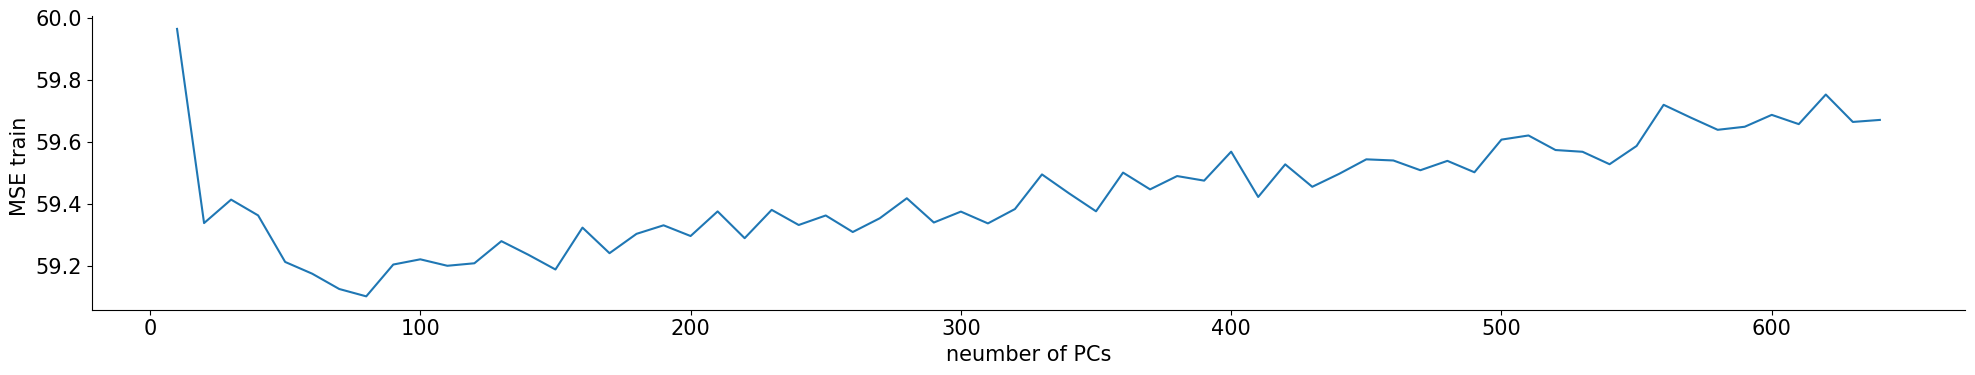

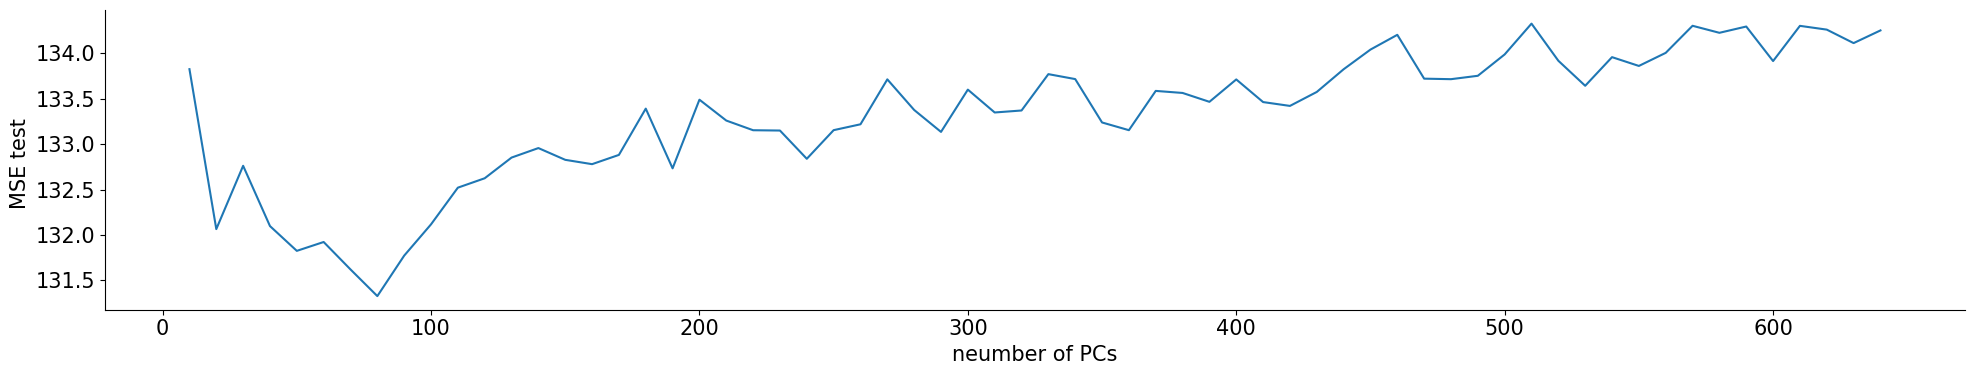

In [26]:
# @title Prining and showing the results of playing with number of PCs in PCA
num_PC = np.arange(10, 645, step = 10)

print("MSE_train: ")
print(errortrain_neuron_num)
plt.figure()
plt.plot(num_PC, errortrain_neuron_num)
plt.xlabel('neumber of PCs')
plt.ylabel('MSE train ')


print("MSE_test: ")
print(errortest_neuron_num)
plt.figure()
plt.plot(num_PC, errortest_neuron_num)
plt.xlabel('neumber of PCs')
plt.ylabel('MSE test ')
